## Construção do modelo de classificação:
Otimização e implantação de um modelo de regressão logística para resolver um problema de classificação binária. O objetivo é comparar a performance de um modelo base com um modelo otimizado via busca em grade (Grid Search), utilizando métricas como AUC-ROC, AUPRC, F1, precisão e recall, para encontrar a melhor configuração do pipeline.

In [1]:
import os

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns



from sklearn.pipeline import Pipeline

from matplotlib.ticker import PercentFormatter

from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.model_selection import cross_val_predict, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.preprocessing import (
    FunctionTransformer,
    LabelEncoder, 
    MinMaxScaler, 
    OneHotEncoder, 
    PowerTransformer,
    StandardScaler,
)

# classificador referência
from sklearn.dummy import DummyClassifier

# estudo lineares
from sklearn.linear_model import LogisticRegression

#matriz de confusão
from sklearn.metrics import ConfusionMatrixDisplay

#para avaliar o permutation importance
from sklearn.model_selection import train_test_split


# exportar o modelo
from joblib import dump, load

# Utilitários internos do projeto (src/)
from src.config import (
    ORIGINAL_DATA,  
    TREATED_DATA, 
    CLASSIFICATION_MODEL, 
    CLUSTERED_DATA
)

from src.graphics import plot_coefficients

from src.models import RANDOM_STATE
from src.models import (
    build_classification_model_pipeline,
    grid_search_cv_classifier,
    train_and_validate_classification_model,
    organize_cv_results,
)

from src.helpers import coefficient_dataframe

sns.set_theme(palette='tab10')


#### 📊 Carregamento e análise inicial dos dados

In [2]:
df = pd.read_parquet(CLUSTERED_DATA)

df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Days_Since_Enrolled,Years_Since_Enrolled,Age_Grouped,Mnt_Total,Mnt_Regular,Children,Has_Children,AcceptedCmpTotal,HasAcceptedCmp,Cluster
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,663,1,46-60,1617,1529,0,0,0,0,1
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,113,0,46-60,27,21,2,1,0,0,0
2,Graduation,Partner,71613.0,0,0,26,426,49,127,111,...,312,0,46-60,776,734,0,0,0,0,1
3,Graduation,Partner,26646.0,1,0,26,11,4,20,10,...,139,0,18-30,53,48,1,1,0,0,0
4,PhD,Partner,58293.0,1,0,94,173,43,118,46,...,161,0,31-45,422,407,1,1,0,0,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2212 entries, 0 to 2211
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Education             2212 non-null   object  
 1   Marital_Status        2212 non-null   object  
 2   Income                2212 non-null   float64 
 3   Kidhome               2212 non-null   int64   
 4   Teenhome              2212 non-null   int64   
 5   Recency               2212 non-null   int64   
 6   MntWines              2212 non-null   int64   
 7   MntFruits             2212 non-null   int64   
 8   MntMeatProducts       2212 non-null   int64   
 9   MntFishProducts       2212 non-null   int64   
 10  MntSweetProducts      2212 non-null   int64   
 11  MntGoldProds          2212 non-null   int64   
 12  NumDealsPurchases     2212 non-null   int64   
 13  NumWebPurchases       2212 non-null   int64   
 14  NumCatalogPurchases   2212 non-null   int64   
 15  NumS

In [4]:
# Agrupamento das colunas de acordo com o pré-processamebto necessário
numerical_features = list(df.select_dtypes("number").columns)
len(numerical_features)

32

#### ⚙️ Separação da variável target e preditoras

In [5]:
X= df.drop("Response", axis=1)
y= df["Response"]

#### Fluxo da Análise:
##### 1. Pré-processamento dos Dados:
Transformação de Variáveis:

Variáveis categóricas: serão codificadas via OneHotEncoder

Variáveis Age e Income: estão próximas da distribuição normal. O StandardScaler é uma boa opção nesse caso.

Variáveis Days Since Enrolled e Recency: possuem distribuição uniforme. O MinMaxScaler irá colocar dentro da escala (padrão 0 e 1)

Variáveis Num e Mnt: a distribuição está enviesada, usarei o Power Transformer para deixar a distribuição mais próxima do normal

In [6]:
#colunas categóricas
one_hot_cols=[
    'Education',
    'Marital_Status',
    'Age_Grouped',
    'Kidhome',
    'Teenhome',
    'AcceptedCmp3',
    'AcceptedCmp4',
    'AcceptedCmp5',
    'AcceptedCmp1',
    'AcceptedCmp2',
    'Complain',
    'Years_Since_Enrolled',
    'Has_Children',
    'Children',
    'AcceptedCmpTotal',
    'HasAcceptedCmp',
    'Cluster'
]


#colunas com a distruibuição próxima a normal
standard_cols= [
    'Income',
    'Age'
]

power_cols= X.columns[
X.columns.str.startswith("Mnt") | X.columns.str.startswith("Num")
].tolist()

minmax_cols = [
    col for col in X.columns if col not in one_hot_cols + standard_cols + power_cols
]

##### 🎯 Codificação da variável alvo

In [7]:
#codificação da coluna target
le = LabelEncoder()

y = le.fit_transform(y.values.ravel())
y

array([1, 0, 0, ..., 0, 0, 1], dtype=int64)

#### 📈 Configuração da validação cruzada e peso para classe minoritária

Quando trabalhamos com problemas de classificação (como este, em que o objetivo é prever a variável Response), é comum que a distribuição das classes seja desbalanceada. Se usarmos uma validação cruzada comum (como o KFold padrão), pode acontecer de alguns folds ficarem com poucas ou nenhuma instância de uma das classes.

✅ A validação cruzada estratificada garante que cada fold mantenha aproximadamente a mesma proporção de classes da variável-alvo (no caso, Response) que o conjunto original. Isso é especialmente importante quando o dataset é desbalanceado, pois evita que o modelo aprenda com dados "viciados".

In [8]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

##### 📊 Modelo sem Otimização

Primeiramente, foi construído um pipeline com:

    * Transformações nas variáveis via ColumnTransformer
    * Seleção de atributos com SelectKBest
    * Classificador: LogisticRegression com class_weight='balanced' para lidar com desbalanceamento.


In [9]:
# Preprocessamento
preprocessing = ColumnTransformer(
    transformers=[
        ("one_hot", OneHotEncoder(drop='first'), one_hot_cols), 
        ("PowerTransformer",PowerTransformer(), power_cols),     
        ("standard", StandardScaler(), standard_cols), 
        ("minmax",MinMaxScaler(feature_range=(-2, 2)), minmax_cols), 
    ]
)

In [10]:
pipeline_logreg = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("feature_selection", SelectKBest(score_func=f_classif)),
        ("model", LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)),  
    ]
)
pipeline_logreg.fit(X,y)
    

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Education',
                                                   'Marital_Status',
                                                   'Age_Grouped', 'Kidhome',
                                                   'Teenhome', 'AcceptedCmp3',
                                                   'AcceptedCmp4',
                                                   'AcceptedCmp5',
                                                   'AcceptedCmp1',
                                                   'AcceptedCmp2', 'Complain',
                                                   'Years_Since_Enrolled',
                                                   'Has_Children', 'Children',
                                                   'AcceptedCmpTotal',
                                                   'HasAcceptedCmp',
                                                   'Cluster']...
                                                   'NumDealsPurchases',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   'NumWebVisitsMonth',
                                                   'Mnt_Total',
                                                   'Mnt_Regular']),
                                                 ('standard', StandardScaler(),
                                                  ['Income', 'Age']),
                                                 ('minmax',
                                                  MinMaxScaler(feature_range=(-2,
                                                                              2)),
                                                  ['Recency',
                                                   'Days_Since_Enrolled'])])),
                ('feature_selection', SelectKBest()),
                ('model',
                 LogisticRegression(class_weight='balanced', random_state=42))])

##### ✔️ Curva ROC
A curva ROC mostra a relação entre taxa de verdadeiros positivos (TPR) e falsos positivos (FPR), ideal para verificar desempenho em diferentes thresholds.

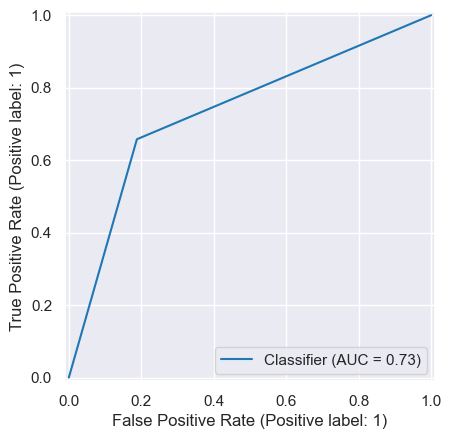

In [11]:
#ROC
y_pred = cross_val_predict(pipeline_logreg, X, y, cv=kf, n_jobs=-1)
roc = RocCurveDisplay.from_predictions(y, y_pred)


##### ✔️ Curva Precision-Recall
É especialmente útil em casos de classes desbalanceadas, pois mostra como a precisão varia com o recall (foca no desempenho da classe positiva). A área sob essa curva (AUPRC) mede a capacidade do modelo de identificar corretamente os positivos com alta confiança.


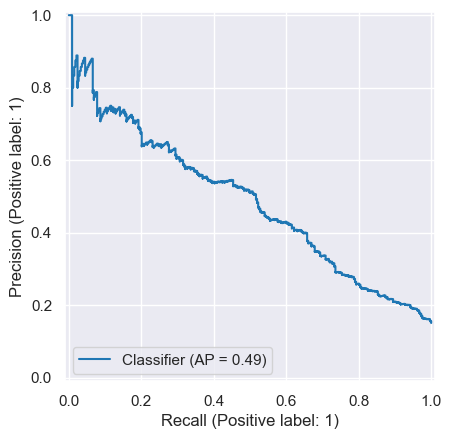

In [12]:
y_pred = cross_val_predict(pipeline_logreg, X, y, cv=kf, n_jobs=-1, method='decision_function')
precision_recall = PrecisionRecallDisplay.from_predictions(y, y_pred)

In [13]:
#otimizar hiperparâmetros
pipeline_logreg.named_steps

{'preprocessing': ColumnTransformer(transformers=[('one_hot', OneHotEncoder(drop='first'),
                                  ['Education', 'Marital_Status', 'Age_Grouped',
                                   'Kidhome', 'Teenhome', 'AcceptedCmp3',
                                   'AcceptedCmp4', 'AcceptedCmp5',
                                   'AcceptedCmp1', 'AcceptedCmp2', 'Complain',
                                   'Years_Since_Enrolled', 'Has_Children',
                                   'Children', 'AcceptedCmpTotal',
                                   'HasAcceptedCmp', 'Cluster']),
                                 ('PowerTransformer', PowerTransf...
                                  ['MntWines', 'MntFruits', 'MntMeatProducts',
                                   'MntFishProducts', 'MntSweetProducts',
                                   'MntGoldProds', 'NumDealsPurchases',
                                   'NumWebPurchases', 'NumCatalogPurchases',
                             

##### 🔧 Otimização com GridSearchCV
Utilização do GridSearchCV para buscar a melhor combinação de parâmetros com múltiplas métricas, escolhendo como métrica principal a average precision.

In [14]:
param_grid= {
    'feature_selection': [SelectKBest(score_func=f_classif, k=k) for k in [15, 22]] + [FunctionTransformer(validate=False)],
    'model__C':np.logspace(-3,3,7),
    'model__solver': ['liblinear', 'saga', 'lbfgs'],
    'model__penalty':['l1', 'l2', 'elasticnet', 'none'],
}


##### Parâmetros
* feature_selection:
    * teste com dois valores de k (15 e 22) para avaliar se a seleção de um subconjunto melhora a performance. Como o dataset é pequeno, também foi testada FunctionTransformer para simular nenhuma seleção (usando todos os atributos).
* model__C (parâmetro de regularização da regressão logística):
    * Valores em escala logarítmica (10^-3 a 10^3) foram testados para capturar sub e sobreajuste.
* model__penalty:
    * Diversos tipos de penalização foram testados: L1 (Lasso), L2 (Ridge), ElasticNet (combinação das duas) e none (sem penalização) para encontrar o melhor viés-bias/variância.
* model__solver:
    * Cada tipo de penalidade exige solvers compatíveis. Mesmo sabendo que algumas combinações irão gerar warnings (e falhar), optamos por deixá-las no grid para explorar ao máximo o espaço de busca.


** warnings.filterwarnings('ignore'): opção por silenciar os avisos de que muitas combinações são incompatíveis entre solver e penalty, mas o GridSearch ignora essas combinações automaticamente.

In [15]:
grid_search = GridSearchCV(
    pipeline_logreg,
    param_grid,
    scoring=['roc_auc', 'average_precision', 'accuracy', 'f1'],
    n_jobs=-1,
    refit = 'average_precision',
    verbose=2
)
grid_search



GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Education',
                                                                          'Marital_Status',
                                                                          'Age_Grouped',
                                                                          'Kidhome',
                                                                          'Teenhome',
                                                                          'AcceptedCmp3',
                                                                          'AcceptedCmp4',
                                                                          'AcceptedCmp5',
                                                                          'AcceptedCmp1',
                                                                          'AcceptedCmp2',
                                                                          'Complain',
                                                                          'Years_Since_Enrolled',
                                                                          'Has_Children',
                                                                          'Children',
                                                                          'AcceptedCmpTotal',
                                                                          'Has...
             n_jobs=-1,
             param_grid={'feature_selection': [SelectKBest(k=15),
                                               SelectKBest(k=22),
                                               FunctionTransformer()],
                         'model__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'model__penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'model__solver': ['liblinear', 'saga', 'lbfgs']},
             refit='average_precision',
             scoring=['roc_auc', 'average_precision', 'accuracy', 'f1'],
             verbose=2)

In [16]:
#warnings de imcompatibilidade com solvers e penaltys são esperados
import warnings
warnings.filterwarnings('ignore')

In [17]:
grid_search.fit(X,y)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Education',
                                                                          'Marital_Status',
                                                                          'Age_Grouped',
                                                                          'Kidhome',
                                                                          'Teenhome',
                                                                          'AcceptedCmp3',
                                                                          'AcceptedCmp4',
                                                                          'AcceptedCmp5',
                                                                          'AcceptedCmp1',
                                                                          'AcceptedCmp2',
                                                                          'Complain',
                                                                          'Years_Since_Enrolled',
                                                                          'Has_Children',
                                                                          'Children',
                                                                          'AcceptedCmpTotal',
                                                                          'Has...
             n_jobs=-1,
             param_grid={'feature_selection': [SelectKBest(k=15),
                                               SelectKBest(k=22),
                                               FunctionTransformer()],
                         'model__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'model__penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'model__solver': ['liblinear', 'saga', 'lbfgs']},
             refit='average_precision',
             scoring=['roc_auc', 'average_precision', 'accuracy', 'f1'],
             verbose=2)

In [18]:
grid_search.best_params_
#explicar o best params em relação a qual métrica e porque

{'feature_selection': FunctionTransformer(),
 'model__C': 1.0,
 'model__penalty': 'l1',
 'model__solver': 'saga'}

##### 📌 Melhores parâmetros encontrados:
* Sem seleção de variáveis (FunctionTransformer()): usar todas as variáveis se mostrou melhor para o desempenho geral.

* C=10.0: regularização mais leve, permitindo maior flexibilidade ao modelo.

* penalty='l2' com solver='saga': combinação estável, eficiente e compatível para L2, especialmente em datasets maiores e esparsos.

In [19]:
grid_search.best_score_

0.6718498615681486

In [20]:
df_results_gs = pd.DataFrame(
    {
        "auprc": grid_search.cv_results_['mean_test_average_precision'],
        "auroc": grid_search.cv_results_['mean_test_roc_auc'],
        "accuracy": grid_search.cv_results_['mean_test_accuracy'],
        "f1": grid_search.cv_results_['mean_test_f1'],
    }
)
df_results_gs        
        

,auprc,auroc,accuracy,f1
0,0.150542,0.500000,0.849458,0.000000
1,0.150542,0.500000,0.569820,0.104621
2,NaN,NaN,NaN,NaN
3,0.420585,0.770731,0.615733,0.376629
4,0.421321,0.771489,0.674510,0.393048
...,...,...,...,...
247,NaN,NaN,NaN,NaN
248,NaN,NaN,NaN,NaN
249,NaN,NaN,NaN,NaN
250,NaN,NaN,NaN,NaN


<Axes: >

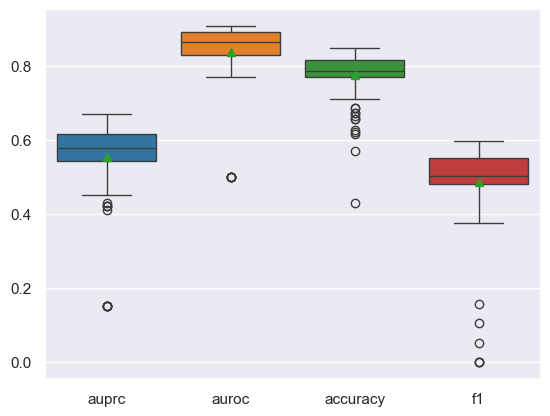

In [21]:
sns.boxplot(
    data=df_results_gs,
    showmeans=True,
)

In [22]:
grid_search.best_params_

{'feature_selection': FunctionTransformer(),
 'model__C': 1.0,
 'model__penalty': 'l1',
 'model__solver': 'saga'}

##### ✅ Pipeline Final com os Melhores Parâmetros

In [23]:
#criar o pipeline usando os melhores parâmetros - automatizando 
pipeline_logreg_best = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("model", LogisticRegression(
            random_state=RANDOM_STATE,
            C= grid_search.best_params_['model__C'],
            penalty=grid_search.best_params_['model__penalty'], 
            solver= grid_search.best_params_['model__solver'],
            class_weight='balanced',
        )),  
    ]
)

##### 📊 Avaliação Final com Cross-Validation

In [24]:
scores= cross_validate(
    pipeline_logreg_best,
    X,
    y,
    cv=kf,
    scoring=['f1', 'precision', 'recall', 'roc_auc', 'average_precision'],
    n_jobs=-1
)

In [25]:
scores

{'fit_time': array([2.08577394, 2.32239676, 2.35963607, 2.39324665, 2.35206032]),
 'score_time': array([0.41899276, 0.40673995, 0.42196822, 0.41515875, 0.44386673]),
 'test_f1': array([0.6043956 , 0.56382979, 0.55958549, 0.60869565, 0.63529412]),
 'test_precision': array([0.47826087, 0.43801653, 0.42857143, 0.47457627, 0.51923077]),
 'test_recall': array([0.82089552, 0.79104478, 0.80597015, 0.84848485, 0.81818182]),
 'test_roc_auc': array([0.90957447, 0.88331613, 0.89387065, 0.92295293, 0.92843327]),
 'test_average_precision': array([0.67432313, 0.63125071, 0.67479704, 0.67097153, 0.70702129])}

In [26]:
scores['time']=scores['fit_time'] + scores['score_time']

In [27]:
df_scores_best = pd.DataFrame(scores)
df_scores_best 

,fit_time,score_time,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time
0,2.085774,0.418993,0.604396,0.478261,0.820896,0.909574,0.674323,2.504767
1,2.322397,0.406740,0.563830,0.438017,0.791045,0.883316,0.631251,2.729137
2,2.359636,0.421968,0.559585,0.428571,0.805970,0.893871,0.674797,2.781604
3,2.393247,0.415159,0.608696,0.474576,0.848485,0.922953,0.670972,2.808405
4,2.352060,0.443867,0.635294,0.519231,0.818182,0.928433,0.707021,2.795927


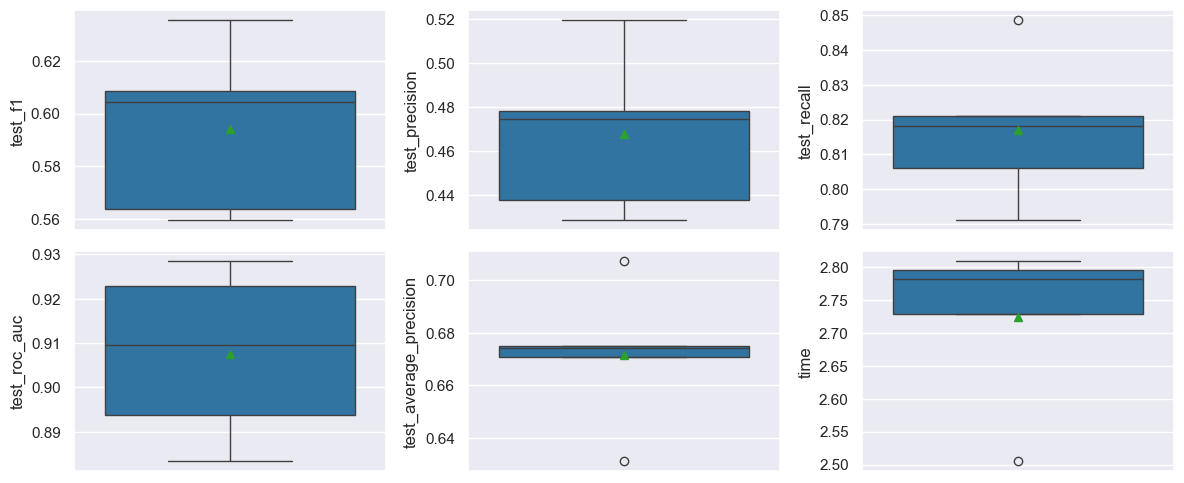

In [28]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,5), tight_layout=True)

cols = df_scores_best.columns[2:].tolist()

for ax, col in zip(axs.flatten(), cols):
    b = sns.boxplot(y=col, data=df_scores_best, ax=ax, showmeans=True)

plt.show()


In [29]:
#analisar as features mais importantes para o) modelo)
pipeline_logreg_best.fit(X,y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Education',
                                                   'Marital_Status',
                                                   'Age_Grouped', 'Kidhome',
                                                   'Teenhome', 'AcceptedCmp3',
                                                   'AcceptedCmp4',
                                                   'AcceptedCmp5',
                                                   'AcceptedCmp1',
                                                   'AcceptedCmp2', 'Complain',
                                                   'Years_Since_Enrolled',
                                                   'Has_Children', 'Children',
                                                   'AcceptedCmpTotal',
                                                   'HasAcceptedCmp',
                                                   'Cluster']...
                                                   'NumDealsPurchases',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   'NumWebVisitsMonth',
                                                   'Mnt_Total',
                                                   'Mnt_Regular']),
                                                 ('standard', StandardScaler(),
                                                  ['Income', 'Age']),
                                                 ('minmax',
                                                  MinMaxScaler(feature_range=(-2,
                                                                              2)),
                                                  ['Recency',
                                                   'Days_Since_Enrolled'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', penalty='l1',
                                    random_state=42, solver='saga'))])

In [30]:
coefs = coefficient_dataframe(
    pipeline_logreg_best['model'].coef_[0],
    pipeline_logreg_best[:-1].get_feature_names_out() #o nome das features
)
coefs

,coefficient
one_hot__Education_Basic,-1.131076
PowerTransformer__MntWines,-1.089576
one_hot__Teenhome_1,-0.938687
minmax__Recency,-0.872235
one_hot__Teenhome_2,-0.822876
PowerTransformer__NumStorePurchases,-0.792626
one_hot__Has_Children_1,-0.530533
one_hot__AcceptedCmpTotal_1,-0.453912
PowerTransformer__Mnt_Regular,-0.431844
one_hot__Children_3,-0.390828


##### 🔍 Análise dos Coeficientes
Ao analisar os coeficientes, percebe-se que as variáveis com valores contínuos possuem uma interpretação ligeiramente diferente das variáveis categóricas. No entanto, em ambos os casos, coeficientes mais negativos indicam maior impacto na probabilidade da classe 0 (falta de engajamento), enquanto coeficientes mais positivos indicam maior impacto na probabilidade da classe 1 (engajamento) da variável target.

Destacam-se entre os coeficientes negativos:

    * Formação básica (nível educacional mais baixo),

    * Gastos com vinhos (quanto menor o gasto, menor o engajamento),

    * Presença de filhos adolescentes,

    * Maior tempo desde a última compra.

Entre os coeficientes positivos, destacam-se:

    * Pessoas com doutorado,

    * Aqueles que aceitaram campanhas promocionais 1 e 5,

    * Solteiros, que apresentaram maior propensão ao engajamento.

A análise dos coeficientes corrobora os padrões observados na análise exploratória e nos agrupamentos por cluster, o que reforça a consistência do modelo com os dados.

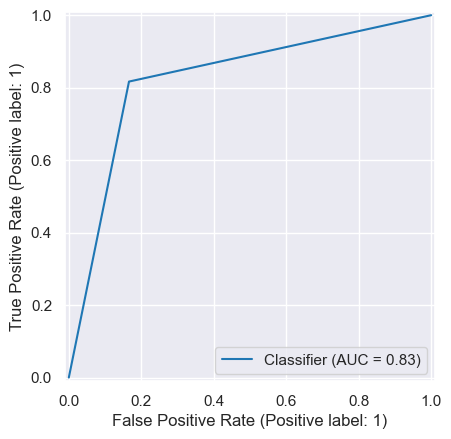

In [32]:
#ROC

y_pred = cross_val_predict(pipeline_logreg_best, X, y, cv=kf, n_jobs=-1)
roc = RocCurveDisplay.from_predictions(y, y_pred)


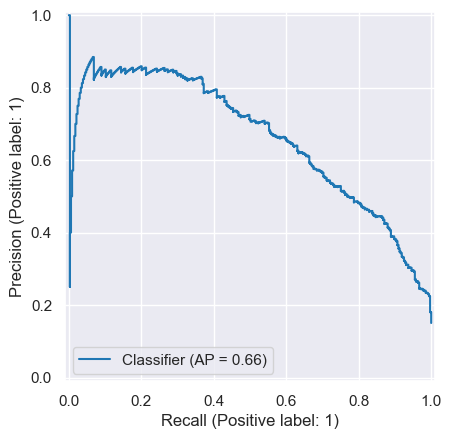

In [33]:
y_pred = cross_val_predict(pipeline_logreg_best, X, y, cv=kf, n_jobs=-1, method='decision_function')
precision_recall = PrecisionRecallDisplay.from_predictions(y, y_pred)

<function matplotlib.pyplot.show(close=None, block=None)>

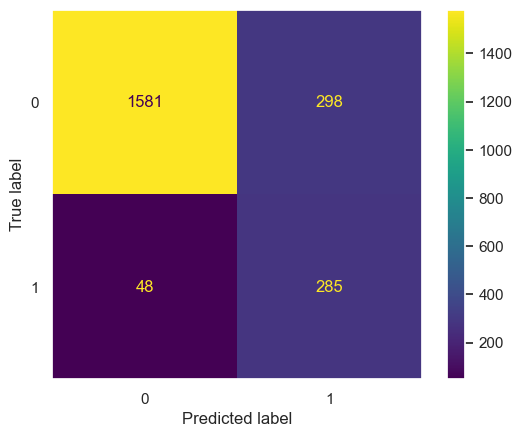

In [34]:
ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_,
    X,
    y,
    display_labels=le.classes_,

)
plt.grid(False)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

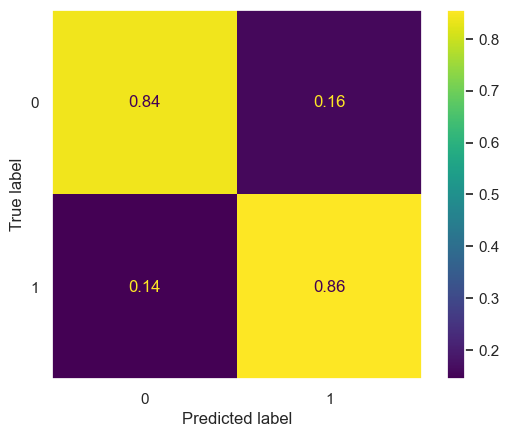

In [35]:
ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_,
    X,
    y,
    display_labels=le.classes_,
    normalize='true',

)
plt.grid(False)
plt.show

#### Conclusão

✅ Conclusão
A otimização dos hiperparâmetros utilizando o GridSearchCV resultou em uma melhora significativa no desempenho do modelo. As principais métricas, como a área sob a curva ROC e a área sob a curva PRC (Precisão-Revocação), apresentaram aumentos expressivos, indicando que o modelo ficou mais eficaz na distinção entre as classes e na detecção de exemplos positivos.

Abaixo, a tabela compara as métricas antes e depois da otimização:


| Métrica                  | Antes da Otimização | Após Otimização |
|--------------------------|---------------------|------------------|
| Área sob a curva ROC     | 73%                 | 83%              |
| Área sob a curva PRC     | 49%                 | 66%              |

Essa melhoria demonstra que o processo de ajuste fino dos hiperparâmetros pode impactar fortemente a performance do modelo, especialmente em problemas com classes desbalanceadas, como neste caso.

In [36]:
joblib.dump(pipeline_logreg_best, CLASSIFICATION_MODEL)


['D:\\ciencias_dados\\python_pratica\\hashtag\\ciencias_dados\\machine_learning\\projeto_clusterizacao_ifood_git\\models\\modelo_class.pkl']